# Design Considerations

## Part 1: Identify FIVE design decisions for this system.
Argue for how this design decision is significant to the system, and your plans to analyze this design. If needed, use the dataset provided to you.

### 1. Class-Specific IOU Thresholds
One factor to consider in designing this object detection system is the IOU threshold, which is used in the Non-Maximal Suppression step of the interference service. This threshold is also used in determining whether or not a predicted bounding box is correctly labeled. If the threshold is high, that means a large degree of overlap would be required to consider two bounding boxes as detecting the same object. This would be useful for classes where objects are frequently close together, like cardboard boxes. However, for objects that are more spread out like cars or forklifts, a lower IOU threshold may be better to eliminate redundant detections during the NMS process. To decide on IOU thresholds per class, we can perform an experimental analysis where we test various IOU thresholds (e.g. 0.3, 0.5, 0.7) and determine calculate model metrics using a validation set partitioned by class, and determine which IOU produces the best performance for each class. Since precision and recall are sensitive to IOU changes, the performance metric used would be the mean average precision, which would also help account for imbalanced classes.

### 2. Image Size
A second factor to consider is the image size. The input images must be resized so that they are all the same size and can be ingested by the model. Larger images contain more information and therefore ideally lead to more accurate detections; however, they're more computationally expensive to process. Smaller images can be processed quicker, but have less information and may lead to less accurate predictions. Another experimental analysis can be done to decide on an appropriate image size. A validation set can be used to calculate the model performance (again using mAP) multiples times, each time processing the images using a different image size. We can then plot images size vs mAP, and if we track processing speed, we can plot image size vs. speed, and find an image size that balances both speed and performance.

### 3. Frame Skipping
Skipping frames can reduce the computational time required to process a video, which can be especially useful for real-time applications like a robotic platform in a warehouse. If we only process one out of every five frames for example, we could process a video in 1/5 of the time it would take to process every frame. The speed and computational efficency comes at the cost of decreased information. Since we're not processing some frames, we're not seeing some data, which may lead worse overall system performance. To find a balance between speed and model performance, we can analyze a video with known detections and run our prediction process on the video, skipping various numbers of frames. We can keep track of procesing time as well as model performance, using the mAP (mean average precision) metric, and then plot both of these values vs. the number of frames skipped. By plotting these 2 relationships, we can identify the number of frames to skip to achieve good performance and speed.

### 4. Detection Ranking Criteria for Hard Negative Mining
Hard negative mining is used to find samples that the model performed the worst on, so they can be used to retrain the model on these difficult input examples. The criteria for ranking the worst performing inputs can be based on confidence score or loss, which is an important design decision to make. The confidence score directly reflects a model's certainty about its prediction, so it's easy to interpret since high-confidence scores with false positives likely indicate that they'll significantly impact model performance. This allows the model to be retrained with the most problematic errors directly. Alternatively, the loss score coprehensively addresses the errors since it accounts for both classification and localization errors, and ensures that both low and high confidence errors are addressed. The loss score can be further tuned by adjusting the lambda parameter that determines how much weight to put on the localization errors vs classification errors. To analyze this factor, an experimental test could be run by using a validation set to calculate the model performance using mAP, running multiple times and retraining using a different ranking criteria for hard negative mining. The criteria that results in the model with best performance should be chosen.

### 5. Dataset Size
Dataset size is another design factor to consider. Increased training dataset size potentially could result in a better performing model if the datast includes good, diverse data that accurately represents test/real world data. However, lack of diversity or balance in the training set could be more likely to lead to overfitting with a larger dataset size. Additionally, larger datasets take longer to train and process than smaller datasets. Another experimental analysis can be done to decide on an appropriate dataset size. A validation set can be used to train the model and calculate the model performance (again using mAP) multiples times, each time processing the images using a different dataset size. We can then plot dataset size vs mAP, and if we track processing speed, we can plot dataset size vs. speed, and find a dataset size that balances both speed and performance. Speed will be important in cases where errors are being made so retraining is required, which ideally should be efficient so that the robot is not out of use for too long.

## Part 2: Analyze TWO out of the five design decisions. Add the results of your analysis.

### Image Size
The first analysis done is comparing the inference time and mean average precision (mAP) for different image sizes when processing and predicting a set of 1000 images. The processing of each image is timed, and the mean image processing time per image size and mAP are plotted vs image size. The results indicate that an image size of 416 may work well since the mean processing time decreases at 416, before increasing again for an image size of 624. However, the mAP results indicate that in image size of 416 produces the lowest mAP while 624 produces the highest mAP. For this reason, I chose to use an image size of 624 in the deployed system and the remaining analyses.

First, we have to import the modules and load the training data and YOLO models.

In [1]:
import sys
sys.path.insert(1,'../')
import os
import cv2
import time
import numpy as np
import random
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
from src.inference import object_detection
from src.inference import non_maximal_suppression
from src.metrics import Metrics, Loss
from src.rectification import hard_negative_mining
import random
random.seed(0)

# Load class names from file
with open('../storages/training/_darknet.labels', 'r') as f:
    classNames = [line.strip() for line in f.readlines()]

# Load training files
num_classes = 20
dataset_dir = '../storages/training'
trainFiles = list(zip(
            sorted(glob(os.path.join(dataset_dir, "*.jpg"))),
            sorted(glob(os.path.join(dataset_dir, "*.txt")))))

# Load models
names_path = "../yolo_resources/logistics.names"
cfg_path1 = "../yolo_resources/yolov4-tiny-logistics_size_416_1.cfg"
weights_path1 = "../yolo_resources/models/yolov4-tiny-logistics_size_416_1.weights"
detector1 = object_detection.YOLOObjectDetector(cfg_path1, weights_path1, names_path)
cfg_path2 = "../yolo_resources/yolov4-tiny-logistics_size_416_2.cfg"
weights_path2 = "../yolo_resources/models/yolov4-tiny-logistics_size_416_2.weights"
detector2 = object_detection.YOLOObjectDetector(cfg_path2, weights_path2, names_path)

Successfully loaded model...
Successfully loaded model...


Run prediction and calculate mean average precision (mAP) for different image sizes.

In [2]:
# Set up NMS
score_threshold = 0.5
iou_threshold = 0.4
nms = non_maximal_suppression.NMS(score_threshold, iou_threshold)

# Run prediction on different image sizes
datasetSize = 1000
imgSizes = [208, 312, 416, 624, 832]
meanTimes = []
stdTimes = []
allTimes = np.zeros([len(imgSizes),datasetSize])

# Generate random sample from training set
sampleSet = random.sample(trainFiles, datasetSize) if datasetSize < len(trainFiles) else trainFiles
maps = []
# Predict all images in a random sample of training set for each dataset size
for i in range(len(imgSizes)):
    imgSize = imgSizes[i]
    # Run prediction on each image in the training set
    pred_scores = []
    gt_class_ids = []
    for j in range(len(sampleSet)):
        image_file, annotation_file = sampleSet[j]
        # Read image and resize
        frame = cv2.imread(image_file)
        start = time.time()
        h, w, _ = frame.shape
        if h != imgSize and w != imgSize:
            frame = cv2.resize(frame, (imgSize,imgSize))
        # Predict
        output = detector2.predict(frame)
        detections = detector2.process_output(output, True)
        filteredDetections = nms.filter(detections, True)
        end = time.time()
        # Keep track of time taken to process the dataset
        allTimes[i,j] = end-start
        # Read true annotations
        annotations = []
        with open(annotation_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                class_label = int(parts[0])
                bbox = list(map(float, parts[1:]))
                annotations.append((class_label, *bbox))
        # Find matching objects
        match_ids, match_scores = Metrics.get_matches(filteredDetections, annotations, iou_threshold, h, w)
        # Keep track of matching objects
        if match_scores.shape[0] > 0:
            pred_scores = np.vstack([pred_scores, match_scores]) if len(pred_scores) > 0 else match_scores
        if len(match_ids) > 0:
            gt_class_ids = np.hstack([gt_class_ids, match_ids]) if len(gt_class_ids) > 0 else match_ids
    # Keep track of mAP
    ms = Metrics.calculate_metrics(gt_class_ids, pred_scores, num_classes)
    maps.append(ms.get('map',0))
    print(f'{imgSize} imgSize: {np.sum(allTimes[i,:]):.4f} sec')

208 imgSize: 19.6629 sec
312 imgSize: 19.5694 sec
416 imgSize: 19.4770 sec
624 imgSize: 19.7722 sec
832 imgSize: 19.8121 sec


Plot results of image size analysis. Time vs image size and mAP vs image size

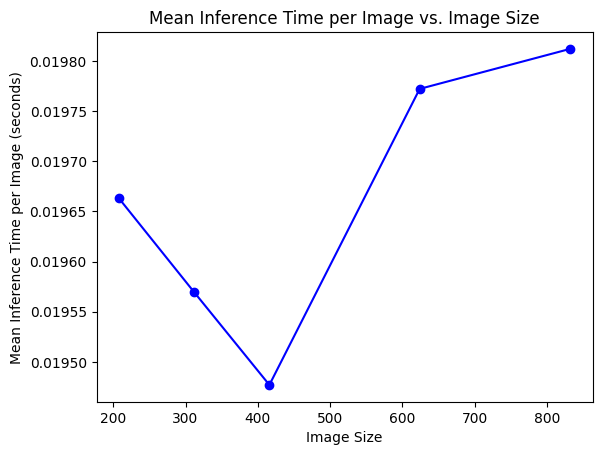

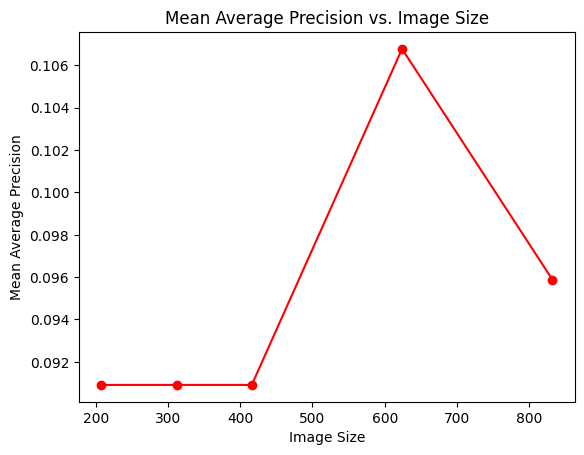

In [3]:
# Calculate average time per image and plot vs image size
meanTimes = np.mean(allTimes,axis=1)
plt.figure()
plt.plot(imgSizes,meanTimes,'bo-')
plt.title('Mean Inference Time per Image vs. Image Size')
plt.xlabel('Image Size')
plt.ylabel('Mean Inference Time per Image (seconds)')
plt.show()
plt.figure()
plt.plot(imgSizes,maps,'ro-')
plt.title('Mean Average Precision vs. Image Size')
plt.xlabel('Image Size')
plt.ylabel('Mean Average Precision')
plt.show()

### Dataset Size
The next analysis done is comparing the time it takes to process different dataset sizes when processing and predicting a set of images. The processing of each dataset is timed, and the processing time is plotted vs dataset size. The results indicate that there's a positive linear relationship between dataset size and processing time, with a slope of roughly 50 images per second. This suggests that the inference service can process up to 50 frames per second. Theoretically, this means that we can meet the system requirement of processing a video stream at 30fps. Accounting for latency and any decrease in speed due to the system running other processes, if we set our skip frames parameter to 2, meaning we process one out of every two frames at 30fps, that means we'd need to process 15 frames per second of the 30fps stream. Additionally, the results showed a higher mAP value for lower dataset size. This led to my choice to use a skip__every_frame parameter value of 2 in the VideoProcessing component of my deployed system.

In [7]:
iou_threshold = 0.4
score_threshold = 0.5
nms = non_maximal_suppression.NMS(score_threshold, iou_threshold)

# Initialize dataset sizes
datasetSizes = [500, 1000, 1500, 2000, 2500]
imgSize = 624
times = []
maps = []

# Predict all images in a random sample of training set for each dataset size
for datasetSize in datasetSizes:
    totalTime = 0
    # Generate random sample from training set
    sampleSet = random.sample(trainFiles, datasetSize) if datasetSize < len(trainFiles) else trainFiles
    # Run prediction on each image in the training set
    pred_scores = []
    gt_class_ids = []
    for image_file, annotation_file in sampleSet:
        start = time.time()
        # Read image and resize
        frame = cv2.imread(image_file)
        h, w, _ = frame.shape
        if h != imgSize and w != imgSize:
            frame = cv2.resize(frame, (imgSize,imgSize))
        # Predict
        output = detector2.predict(frame)
        detections = detector2.process_output(output, True)
        filteredDetections = nms.filter(detections, True)
        end = time.time()
        totalTime += (end-start)
        # Read true annotations
        annotations = []
        with open(annotation_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                class_label = int(parts[0])
                bbox = list(map(float, parts[1:]))
                annotations.append((class_label, *bbox))
        # Find matching objects
        match_ids, match_scores = Metrics.get_matches(filteredDetections, annotations, iou_threshold, h, w)
        # Keep track of matching objects
        if match_scores.shape[0] > 0:
            pred_scores = np.vstack([pred_scores, match_scores]) if len(pred_scores) > 0 else match_scores
        if len(match_ids) > 0:
            gt_class_ids = np.hstack([gt_class_ids, match_ids]) if len(gt_class_ids) > 0 else match_ids
    # Keep track of inference time taken for the whole dataset
    times.append(totalTime)
    # Keep track of mAP
    ms = Metrics.calculate_metrics(gt_class_ids, pred_scores, num_classes)
    maps.append(ms.get('map',0))
    print(f'{datasetSize} imgs: {totalTime:.4f} sec')

500 imgs: 10.6052 sec
1000 imgs: 21.1103 sec
1500 imgs: 31.6870 sec
2000 imgs: 42.2348 sec
2500 imgs: 52.8861 sec


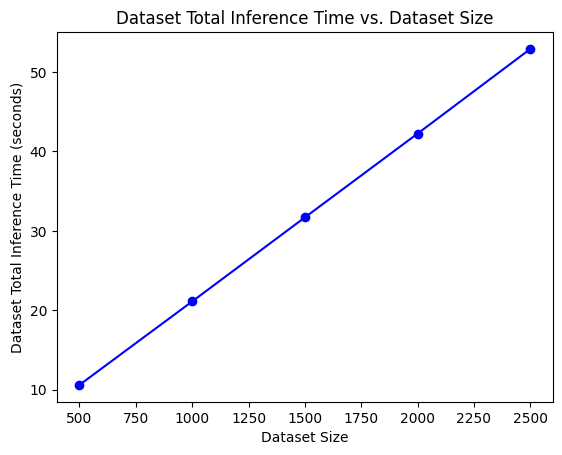

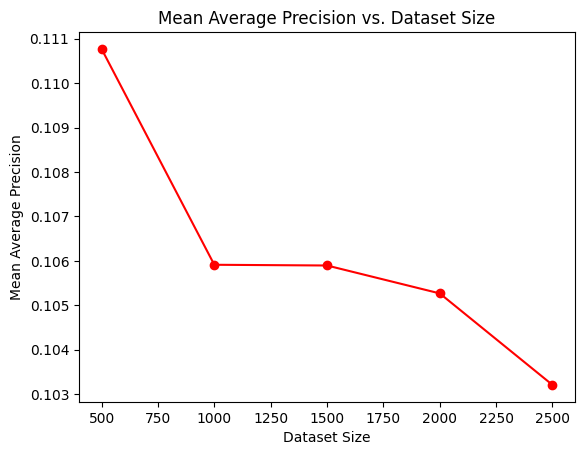

In [13]:
plt.figure()
plt.plot(datasetSizes,times,'bo-')
plt.title('Dataset Total Inference Time vs. Dataset Size')
plt.xlabel('Dataset Size')
plt.ylabel('Dataset Total Inference Time (seconds)')
plt.show()
plt.figure()
plt.plot(datasetSizes,maps,'ro-')
plt.title('Mean Average Precision vs. Dataset Size')
plt.xlabel('Dataset Size')
plt.ylabel('Mean Average Precision')
plt.show()

## Additional Analyses
Four additional analyses beyond the minimum of 2 required analyses.

### mAP vs IOU Threshold
I performed this analysis using both trained versions of the YOLO Object Detection Models. By running the inference service and calculating the mAP for 1000 images, repeating with different IOU thresholds of [0.1, 0.3, 0.5, 0.7, 0.9], I was able to plot the mAP vs IOU Threshold. The results indicate that mAP decreases almost linearly (but not quite) as IOU increases. This makes sense that mAP may be decreased with higher (stricter) IOU threshold since there would likely be less matches between predictions and ground truth labels. This led to my choice to use an IOU threshold of 0.3 in my deployed system and for the remaining analyses. Although 0.1 produced the highest mAP, this seemed to low to adequately distinguish between objects that may be close together in real world data. Additionally, the results showed the Model 2 had a higher mAP than Model 1 for all IOU thresholds, so I chose to use Model 2 in my deployed system and remaining analyses.

In [9]:
# Run prediction with different IOU thresholds
datasetSize = 1000
score_threshold = 0.5
imgSize = 624
iou_thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]

# Generate random sample from training set
sampleSet = random.sample(trainFiles, datasetSize) if datasetSize < len(trainFiles) else trainFiles
maps1 = []
maps2 = []
# Predict all images in a random sample of training set for each dataset size
for i in range(len(iou_thresholds)):
    iou_threshold = iou_thresholds[i]
    # Set up NMS
    nms = non_maximal_suppression.NMS(score_threshold, iou_threshold)
    # Run prediction on each image in the training set
    pred_scores1 = []
    gt_class_ids1 = []
    pred_scores2 = []
    gt_class_ids2 = []
    for image_file, annotation_file in sampleSet:
        # Read image and resize
        frame = cv2.imread(image_file)
        h, w, _ = frame.shape
        if h != imgSize and w != imgSize:
            frame = cv2.resize(frame, (imgSize,imgSize))
        # Predict using model 1
        output1 = detector1.predict(frame)
        detections1 = detector1.process_output(output1, True)
        filteredDetections1 = nms.filter(detections1, True)
        # Predict using model 2
        output2 = detector2.predict(frame)
        detections2 = detector2.process_output(output2, True)
        filteredDetections2 = nms.filter(detections2, True)
        # Read true annotations
        annotations = []
        with open(annotation_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                class_label = int(parts[0])
                bbox = list(map(float, parts[1:]))
                annotations.append((class_label, *bbox))
        # Find matching objects
        match_ids1, match_scores1 = Metrics.get_matches(filteredDetections1, annotations, iou_threshold, h, w)
        match_ids2, match_scores2 = Metrics.get_matches(filteredDetections2, annotations, iou_threshold, h, w)
        # Keep track of matching objects
        if match_scores1.shape[0] > 0:
            pred_scores1 = np.vstack([pred_scores1, match_scores1]) if len(pred_scores1) > 0 else match_scores1
        if len(match_ids1) > 0:
            gt_class_ids1 = np.hstack([gt_class_ids1, match_ids1]) if len(gt_class_ids1) > 0 else match_ids1
        if match_scores2.shape[0] > 0:
            pred_scores2 = np.vstack([pred_scores2, match_scores2]) if len(pred_scores2) > 0 else match_scores2
        if len(match_ids2) > 0:
            gt_class_ids2 = np.hstack([gt_class_ids2, match_ids2]) if len(gt_class_ids2) > 0 else match_ids2
    # Keep track of mAP
    ms1 = Metrics.calculate_metrics(gt_class_ids1, pred_scores1, num_classes)
    maps1.append(ms1.get('map',0))
    ms2 = Metrics.calculate_metrics(gt_class_ids2, pred_scores2, num_classes)
    maps2.append(ms2.get('map',0))
    print(f'IOU = {iou_threshold} done')

IOU = 0.1 done
IOU = 0.3 done
IOU = 0.5 done
IOU = 0.7 done
IOU = 0.9 done


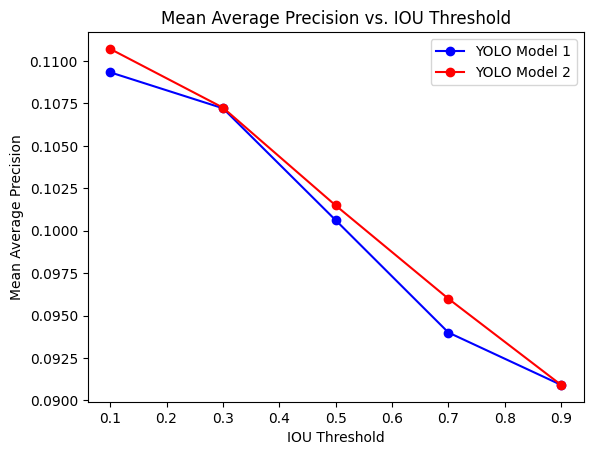

In [11]:
# Plot mAP vs IOU Threshold for both models
plt.figure()
plt.plot(iou_thresholds,maps1,'bo-', label='YOLO Model 1')
plt.plot(iou_thresholds,maps2,'ro-', label='YOLO Model 2')
plt.title('Mean Average Precision vs. IOU Threshold')
plt.xlabel('IOU Threshold')
plt.ylabel('Mean Average Precision')
plt.legend()
plt.show()

### mAP vs Score Threshold
I performed this analysis using both trained versions of the YOLO Object Detection Models. By running the inference service and calculating the mAP for 1000 images, repeating with different score thresholds of [0.1, 0.3, 0.5, 0.7, 0.9], I was able to plot the mAP vs IOU Threshold. The results indicate that mAP decreases almost linearly (but not quite) as score threshold increases. This makes sense that mAP may be decreased with higher (stricter) confidence score threshold since there would likely be less matches when determining overlapping boxes in NMS, resulting in more redundant detections. This led to my choice to use a score threshold of 0.3 in my deployed system and for the remaining analyses. Although 0.1 produced the highest mAP, this seemed to low to adequately distinguish between objects that may be close together in real world data. Additionally, the results showed the Model 2 had a higher mAP than Model 1 for all score thresholds, except 0.3 where the mAP was roughly the same, so this confirmed my choice to use 0.3 threshold and Model 2 in my deployed system and remaining analyses.

In [12]:
# Run prediction on different score thresholds
datasetSize = 1000
imgSize = 624
iou_threshold = 0.3
score_thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]

# Generate random sample from training set
sampleSet = random.sample(trainFiles, datasetSize) if datasetSize < len(trainFiles) else trainFiles
maps1 = []
maps2 = []
# Predict all images in a random sample of training set for each dataset size
for i in range(len(score_thresholds)):
    score_threshold = score_thresholds[i]
    # Set up NMS
    nms = non_maximal_suppression.NMS(score_threshold, iou_threshold)
    # Run prediction on each image in the training set
    pred_scores1 = []
    gt_class_ids1 = []
    pred_scores2 = []
    gt_class_ids2 = []
    for image_file, annotation_file in sampleSet:
        # Read image and resize
        frame = cv2.imread(image_file)
        h, w, _ = frame.shape
        if h != imgSize and w != imgSize:
            frame = cv2.resize(frame, (imgSize,imgSize))
        # Predict using model 1
        output1 = detector1.predict(frame)
        detections1 = detector1.process_output(output1, True)
        filteredDetections1 = nms.filter(detections1, True)
        # Predict using model 2
        output2 = detector2.predict(frame)
        detections2 = detector2.process_output(output2, True)
        filteredDetections2 = nms.filter(detections2, True)
        # Read true annotations
        annotations = []
        with open(annotation_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                class_label = int(parts[0])
                bbox = list(map(float, parts[1:]))
                annotations.append((class_label, *bbox))
        # Find matching objects
        match_ids1, match_scores1 = Metrics.get_matches(filteredDetections1, annotations, iou_threshold, h, w)
        match_ids2, match_scores2 = Metrics.get_matches(filteredDetections2, annotations, iou_threshold, h, w)
        # Keep track of matching objects
        if match_scores1.shape[0] > 0:
            pred_scores1 = np.vstack([pred_scores1, match_scores1]) if len(pred_scores1) > 0 else match_scores1
        if len(match_ids1) > 0:
            gt_class_ids1 = np.hstack([gt_class_ids1, match_ids1]) if len(gt_class_ids1) > 0 else match_ids1
        if match_scores2.shape[0] > 0:
            pred_scores2 = np.vstack([pred_scores2, match_scores2]) if len(pred_scores2) > 0 else match_scores2
        if len(match_ids2) > 0:
            gt_class_ids2 = np.hstack([gt_class_ids2, match_ids2]) if len(gt_class_ids2) > 0 else match_ids2
    # Keep track of mAP
    ms1 = Metrics.calculate_metrics(gt_class_ids1, pred_scores1, num_classes)
    maps1.append(ms1.get('map',0))
    ms2 = Metrics.calculate_metrics(gt_class_ids2, pred_scores2, num_classes)
    maps2.append(ms2.get('map',0))
    print(f'Score threshold = {score_threshold} done')

Score threshold = 0.1 done
Score threshold = 0.3 done
Score threshold = 0.5 done
Score threshold = 0.7 done
Score threshold = 0.9 done


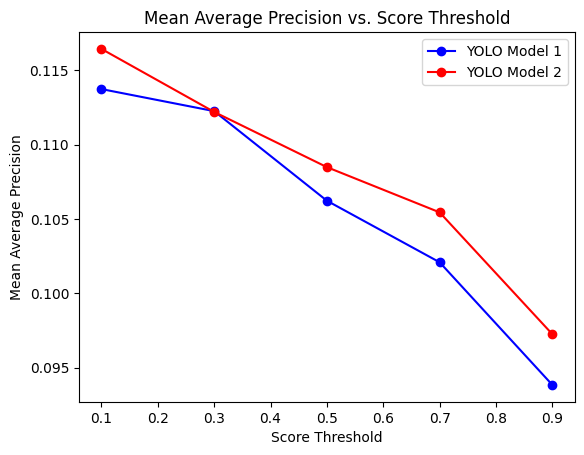

In [14]:
# Plot mAP vs Score Threshold for both models
plt.figure()
plt.plot(score_thresholds,maps1,'bo-', label='YOLO Model 1')
plt.plot(score_thresholds,maps2,'ro-', label='YOLO Model 2')
plt.title('Mean Average Precision vs. Score Threshold')
plt.xlabel('Score Threshold')
plt.ylabel('Mean Average Precision')
plt.legend()
plt.show()

### AP vs Object Class
I performed this analysis using both trained versions of the YOLO Object Detection Models. By running the inference service for 1000 images and calculating the Average Precision for each object class, I was able to plot the AP vs Object Class. The results indicate that AP is the same for all classes and for both models. This was surprising, especially due to the differences in number of objects per class among the 1000 sampled images. The results may be odd due to randomly sampling 1000 out of the 9525 representative training images. With more computational resources, repeating this analysis on the whole training set would be ideal. Additionally, I calculated the AP using the mAP function, but only passing the ids and scores for a single class at a time, with num_classes=1. I thought this should work adequately since I set num_classes=1, but if this doesn't work like I thought it would, then this may have caused unexpected results. Regardless, based on these results, this led to my choice to use a consistent IOU threshold of 0.3 across all classes in my deployed system, instead of investigating class-specific IOU thresholds. I know that this analysis didn't directly test the affect of IOU thresholds on performance for specific classes, and given more time, I would preform the IOU threshold test mentioned above, specifically on single classes of data at a time. However, the consistent results across all classes here led me to believe that the system performs equally well (or not well) on all classes, so the class-specific IOU threshold test was not needed for now. It would be needed for more class-specific tuning.

In [15]:
# Find AP by class
datasetSize = 1000
score_threshold = 0.3
imgSize = 624
iou_threshold = 0.3
nms = non_maximal_suppression.NMS(score_threshold, iou_threshold)

# Generate random sample from training set
sampleSet = random.sample(trainFiles, datasetSize) if datasetSize < len(trainFiles) else trainFiles
maps1 = []
maps2 = []

# Run prediction on each image in the training set
pred_scores1 = []
gt_class_ids1 = []
pred_scores2 = []
gt_class_ids2 = []
for image_file, annotation_file in sampleSet:
    # Read image and resize
    frame = cv2.imread(image_file)
    h, w, _ = frame.shape
    if h != imgSize and w != imgSize:
        frame = cv2.resize(frame, (imgSize,imgSize))
    # Predict using model 1
    output1 = detector1.predict(frame)
    detections1 = detector1.process_output(output1, True)
    filteredDetections1 = nms.filter(detections1, True)
    # Predict using model 2
    output2 = detector2.predict(frame)
    detections2 = detector2.process_output(output2, True)
    filteredDetections2 = nms.filter(detections2, True)
    # Read true annotations
    annotations = []
    with open(annotation_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            class_label = int(parts[0])
            bbox = list(map(float, parts[1:]))
            annotations.append((class_label, *bbox))
    # Find matching objects
    match_ids1, match_scores1 = Metrics.get_matches(filteredDetections1, annotations, iou_threshold, h, w)
    match_ids2, match_scores2 = Metrics.get_matches(filteredDetections2, annotations, iou_threshold, h, w)
    # Keep track of matching objects
    if match_scores1.shape[0] > 0:
        pred_scores1 = np.vstack([pred_scores1, match_scores1]) if len(pred_scores1) > 0 else match_scores1
    if len(match_ids1) > 0:
        gt_class_ids1 = np.hstack([gt_class_ids1, match_ids1]) if len(gt_class_ids1) > 0 else match_ids1
    if match_scores2.shape[0] > 0:
        pred_scores2 = np.vstack([pred_scores2, match_scores2]) if len(pred_scores2) > 0 else match_scores2
    if len(match_ids2) > 0:
        gt_class_ids2 = np.hstack([gt_class_ids2, match_ids2]) if len(gt_class_ids2) > 0 else match_ids2

# Keep track of AP per class
for i in range(num_classes):
    rowMask1 = gt_class_ids1 == i
    rowMask2 = gt_class_ids2 == i
    ms1 = Metrics.calculate_metrics(np.ones([np.sum(rowMask1),1]), pred_scores1[:,i], 1)
    maps1.append(ms1.get('map',0))
    ms2 = Metrics.calculate_metrics(np.ones([np.sum(rowMask2),1]), pred_scores2[:,i], 1)
    maps2.append(ms2.get('map',0))

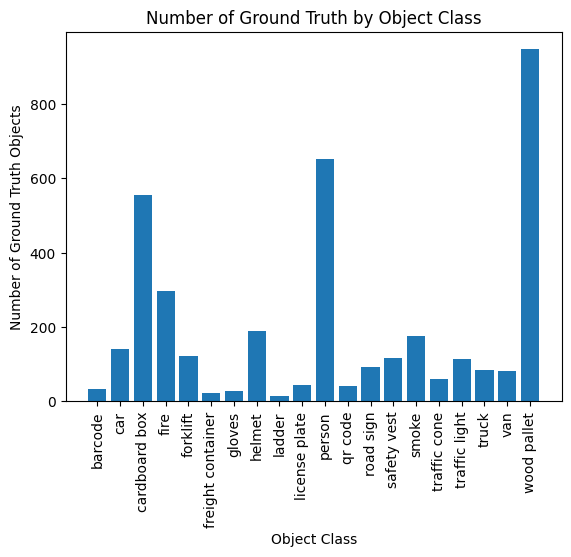

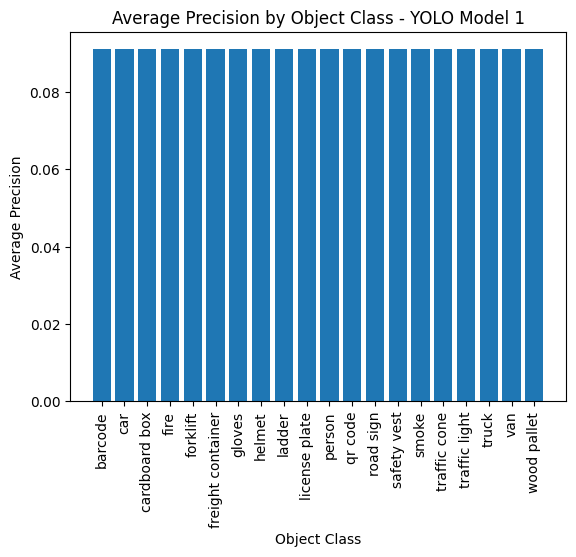

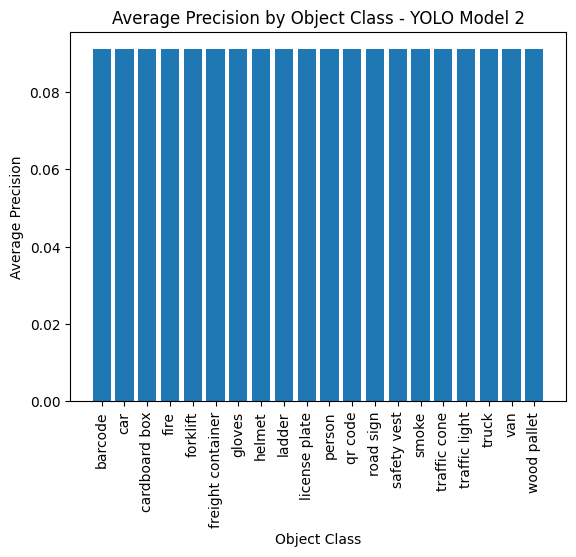

In [17]:
# Plot num objects by class
numClassObjs = [np.sum(gt_class_ids1 == i) for i in range(num_classes)]
plt.figure()
plt.bar(classNames,numClassObjs)
plt.xticks(rotation=90)
plt.title('Number of Ground Truth by Object Class')
plt.xlabel('Object Class')
plt.ylabel('Number of Ground Truth Objects')
plt.show()
# Plot AP by class for both models
plt.figure()
plt.bar(classNames,maps1)
plt.xticks(rotation=90)
plt.title('Average Precision by Object Class - YOLO Model 1')
plt.xlabel('Object Class')
plt.ylabel('Average Precision')
plt.show()
plt.figure()
plt.bar(classNames,maps2)
plt.xticks(rotation=90)
plt.title('Average Precision by Object Class - YOLO Model 2')
plt.xlabel('Object Class')
plt.ylabel('Average Precision')
plt.show()

### mAP vs Hard Negative Ranking
I performed this analysis using only Model 2 since it was determined to perform better than Model 1 in the above analyses. By running the hard negative miner for 1000 images, and then running the inference service on the results and calculating the Mean Average Precision for subsets of 100 images at a time, I was able to plot the mAP vs hard negative ranking. The results indicate that mAP increases as the hard negative ranking number gets higher (i.e. ranked lower). This confirms that the hard negative mining module seems to be working as expected, since we'd expect the highest ranked hard negatives to have the worst performance when provided to the model for inference. This is because the highest ranked hard negatives are supposed to be the hardest for the model to detect, i.e. the most erroneous, resulting in the worst mAP value. The lowest ranked hard negatives should have a higher mAP value because they should be easier for the model to detect. This is good because we know that we'll be retraining the model on the right data in the rectification service, resulting ideally in the largest gains in model performance improvement after retraining on the highest ranked hard negatives.

In [22]:
# Hard Negative Mining
score_threshold = 0.3
iou_threshold = 0.3
nms = non_maximal_suppression.NMS(score_threshold, iou_threshold)
loss_parameters = {'num_classes': num_classes, 'lambda_coord': 5., 'lambda_noobj': 1.}
miner = hard_negative_mining.HardNegativeMiner(model=detector2, nms=nms, measure=Loss(**loss_parameters), dataset_dir=dataset_dir)
N = 1000
hard_negatives = miner.sample_hard_negatives(N, criteria='total_loss', sample_size=N)
print(hard_negatives.head(5))

                                     annotation_file  \
0  ../storages/training/1574676347-6351035_jpg.rf...   
1  ../storages/training/1855963-7094_jpg.rf.8115e...   
2  ../storages/training/net-1540-_jpg.rf.a3bc65ac...   
3  ../storages/training/1574675382-065554_jpg.rf....   
4  ../storages/training/1574675213-1575463_jpg.rf...   

                                          image_file    total_loss  \
0  ../storages/training/1574676347-6351035_jpg.rf...  48597.410442   
1  ../storages/training/1855963-7094_jpg.rf.8115e...  23569.662036   
2  ../storages/training/net-1540-_jpg.rf.a3bc65ac...  23554.792696   
3  ../storages/training/1574675382-065554_jpg.rf....  21129.527999   
4  ../storages/training/1574675213-1575463_jpg.rf...  19574.011487   

  loc_loss (lambda=5.0)  conf_loss_obj conf_loss_noobj (lambda=1.0)  \
0                   NaN   35738.893235                          NaN   
1                   NaN   18150.576351                          NaN   
2                   NaN   170

In [23]:
# Run detection model on the hard negatives and calcualte mAP for each subset
imgSize = 624
chunkSize = int(N/10)
pred_scores = []
gt_class_ids = []
maps=[]
for i in range(0, len(hard_negatives),chunkSize):
    hardNegs = hard_negatives.loc[i:i+chunkSize-1,['image_file','annotation_file']]
    for image_file, annotation_file in list(hardNegs.itertuples(index=False, name=None)):
        # Read image and resize
        frame = cv2.imread(image_file)
        h, w, _ = frame.shape
        if h != imgSize and w != imgSize:
            frame = cv2.resize(frame, (imgSize,imgSize))
        # Predict
        output = detector2.predict(frame)
        detections = detector2.process_output(output, True)
        filteredDetections = nms.filter(detections, True)
        # Read true annotations
        annotations = []
        with open(annotation_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                class_label = int(parts[0])
                bbox = list(map(float, parts[1:]))
                annotations.append((class_label, *bbox))
        # Find matching objects
        match_ids, match_scores = Metrics.get_matches(filteredDetections, annotations, iou_threshold, h, w)
        # Keep track of matching objects
        if match_scores.shape[0] > 0:
            pred_scores = np.vstack([pred_scores, match_scores]) if len(pred_scores) > 0 else match_scores
        if len(match_ids) > 0:
            gt_class_ids = np.hstack([gt_class_ids, match_ids]) if len(gt_class_ids) > 0 else match_ids
    # Keep track of mAP
    ms = Metrics.calculate_metrics(gt_class_ids, pred_scores, num_classes)
    maps.append(ms.get('map',0))
    print(f'{i}-{i+chunkSize-1}: done')
    

0-99: done
100-199: done
200-299: done
300-399: done
400-499: done
500-599: done
600-699: done
700-799: done
800-899: done
900-999: done


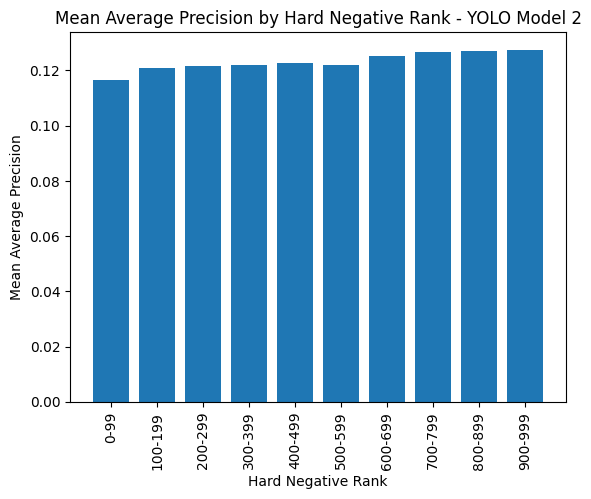

In [24]:
# Plot mAP of each subset of hard negatives
xlabels = [f'{i}-{i+chunkSize-1}' for i in range(0, len(hard_negatives),chunkSize)]
plt.figure()
plt.bar(xlabels,maps)
plt.xticks(rotation=90)
plt.title('Mean Average Precision by Hard Negative Rank - YOLO Model 2')
plt.xlabel('Hard Negative Rank')
plt.ylabel('Mean Average Precision')
plt.show()